# Análise Exploratória - Atividades Econômicas Potenciais

## Sobre este notebook

O objetivo deste notebook é fazer um breve resumo sobre a geografia e indicadores sociais do município potencial escolhido e, em seguida realizar uma análise para entender quais produtos agrícolas produzidos atualmente são subexplorados.

Para isso, foi realizada uma análise comparativa entre o município potencial e seus vizinhos, tanto do ponto de vista geográfico quanto ambiental. Após a identificação dos vizinhos, foi feita a comparação entre os produtos agrícolas mais produzidos pelo município potencial e a produção média de seus vizinhos. A partir deste ponto, foi possível identificar os primeiros sinais de subexploração de um produto agrícola.

Dentre os municípios vizinhos identificados, um demonstrou ser uma grande referência local na exploração do produto agrícola potencial identificado. As análises subsequentes tiveram como objetivo validar se o município potencial e o seu vizinho mais notável compartilhavam as mesmas condições ambientais, de modo a validar uma possível replicação da atividade exploratória em seu território.

Por fim, foram feitas análises para validar o potencial de expansão agrícola do município, sua capacidade geológica e climática para plantar o produto potencial e foi feita uma projeção do impacto que essa exploração pode gerar na sociedade.

# 1) Imports

In [1]:
import secrets
import string
import folium
import pandas as pd 
import numpy as np
import warnings
import geopandas as gpd
import joblib as jb
import seaborn as sns
import matplotlib.pyplot as plt
from millify import millify
from shapely import wkt
from shapely.geometry import shape
from geopy.distance import great_circle

warnings.filterwarnings('ignore')

# 2) Funções

In [15]:
def carregar_municipios_sertao():
    all_muns = pd.read_csv(r"../Dados/Tabela_final/municipios_clusters.csv")
    lim_muns = pd.read_json(r'../Dados/Views/municipios-poligonos.json')
    lim_muns['poligono'] = [str(polygon) for polygon in lim_muns['poligono']]
    lim_muns['geometry'] = lim_muns['poligono'].apply(lambda x: shape(eval(x)))
    lim_muns = lim_muns[['municipioCodigo', 'geometry']].rename(columns={'municipioCodigo':'IBGE7'})
    all_muns = all_muns.merge(lim_muns, on = 'IBGE7', how = 'inner')
    all_muns = gpd.GeoDataFrame(all_muns, geometry='geometry')
    all_muns = all_muns.set_crs("EPSG:4326")
    return all_muns

def carregar_agro():
    agro = pd.read_csv(r"../Dados/Tabela_final/dados_producao_agricola.csv").drop(columns='Unnamed: 0')
    agro['VALOR_PROD'] = agro['VALOR_PROD']*1000
    agro['REND_AREA'] = agro['REND_AREA']*1000
    return agro

def carregar_solos(_all_muns):
    solos = pd.read_csv(r"../Dados/Views/solos_municipios.csv").drop(columns='Unnamed: 0')
    solos = _all_muns[['IBGE7', 'NOME']].merge(solos, on = 'IBGE7', how = 'inner').drop(columns='IBGE7')
    solos['AREA_TOTAL'] = round(solos['AREA_TOTAL'],2)
    return solos

def carregar_dados_mapa():
    dados_mapa = pd.read_csv(r"../Dados/Views/dados_mapa.csv")
    lim_muns = pd.read_json(r'../Dados/Views/municipios-poligonos.json')
    lim_muns['poligono'] = [str(polygon) for polygon in lim_muns['poligono']]
    lim_muns['geometry'] = lim_muns['poligono'].apply(lambda x: shape(eval(x)))
    lim_muns = lim_muns[['municipioCodigo', 'geometry']].rename(columns={'municipioCodigo':'IBGE7'})
    dados_mapa = dados_mapa.merge(lim_muns, on = 'IBGE7', how = 'inner')
    dados_mapa = gpd.GeoDataFrame(dados_mapa, geometry='geometry')
    dados_mapa = dados_mapa.set_crs("EPSG:4326")
    return dados_mapa

def carregar_dados_knn():
    dados_knn = pd.read_csv(r"../Dados/Views/dataset_knn_processado.csv")
    return dados_knn

def muns_prox_geo(_mun_df, _all_muns, _raio):
    coordenadas_mun = (_mun_df['LATITUDE'].iloc[0], _mun_df['LONGITUDE'].iloc[0])
    muns_prox = {}
    for _, row in _all_muns.iterrows():
        coordenadas_muns_prox = (row['LATITUDE'], row['LONGITUDE'])
        distancia = great_circle(coordenadas_mun, coordenadas_muns_prox).kilometers
        if distancia <= _raio:
            muns_prox[row['IBGE7']] = round(distancia,2)
    return muns_prox

def dados_para_plot():
    biomas_municipais = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", 
                                      sheet_name="TRANSICOES_COL8.0")
    biomas_municipais = biomas_municipais[["geocode", "state_acronym", "from_level_2", "to_level_2", "1985-2022"]]
    biomas_municipais.rename(columns={"geocode":"IBGE7", "state_acronym":"UF"}, inplace=True)
    condicao_agricultura = (biomas_municipais["to_level_2"].isin(["Agriculture", "Mosaic of Agriculture and Pasture"]))
    biomas_municipais = biomas_municipais[condicao_agricultura].reset_index(drop=True)
    biomas_municipais_melted = biomas_municipais.melt(id_vars=["UF","IBGE7", "to_level_2", "from_level_2"], 
                                                            value_name="AREA_TRANSICAO",
                                                            value_vars="1985-2022")
    agrupado = biomas_municipais_melted.groupby(by=["UF", "IBGE7", "from_level_2"])[["AREA_TRANSICAO"]].sum()
    agrupado["AREA_TRANSICAO_MEDIA_ANUAL"] = agrupado["AREA_TRANSICAO"] / 38
    dados_biomas = agrupado.reset_index().sort_values(by=["IBGE7", "AREA_TRANSICAO_MEDIA_ANUAL"], ascending=[True, False])
    return dados_biomas


def dados_tendencia_agricultura():    
    biomas_municipais = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", sheet_name="COBERTURA_COL8.0")
    biomas_municipais.drop(columns=["biome [municipality]", "biome", "feature_id", "class_id"], inplace=True)
    biomas_municipais.rename(columns={"geocode":"IBGE7", "municipality":"NOME", "state_acronym":"UF"}, inplace=True)
    biomas_agrupados = biomas_municipais.groupby(["UF","IBGE7", "level_2", "NOME"])[list(range(1985, 2023))].sum().reset_index()
    biomas_agrupados_cidade = biomas_agrupados[(biomas_agrupados["level_2"] == "Agriculture")]
    serie_agricultura = biomas_agrupados_cidade.melt(id_vars=["UF","IBGE7", "level_2", "NOME"], 
                             var_name="ANO", 
                             value_name="AREA_AGRICULTURA")
    serie_agricultura
    return serie_agricultura

def plot_tendencia(dados_tendencia):
    nome = dados_tendencia["NOME"].values[0]
    dados_tendencia.plot(kind="line", x="ANO", y="AREA_AGRICULTURA", color="g")
    plt.title(f"Dinâmica da área da agricultura em {nome}")
    plt.ylabel("Área de agricultura (Ha)");


def muns_prox_knn(dados_knn, model_knn, mun_cod, k):
    mun_df = dados_knn[dados_knn['IBGE7'] == mun_cod].drop(columns=['IBGE7', 'NOME','Unnamed: 0'])
    _, neighbours = model_knn.kneighbors(mun_df, n_neighbors=k+1)
    neighbours = neighbours[0][1:]
    muns_prox = dados_knn['IBGE7'].iloc[neighbours].values
    return muns_prox

def carregar_mapa(mun_cod):
    
    centroids = dados_mapa[['IBGE7', 'geometry']]
    centroids.crs = 'epsg:32724'
    lat = centroids[centroids['IBGE7'] == mun_cod].centroid.y
    long = centroids[centroids['IBGE7'] == mun_cod].centroid.x
    
    m = folium.Map(location=[lat, long], zoom_start=8.5)
    
    folium.Marker(
        location=[
            centroids[centroids['IBGE7'] == mun_cod].centroid.y,
            centroids[centroids['IBGE7'] == mun_cod].centroid.x
        ],
        icon=folium.Icon(color='red')
    ).add_to(m)
    
    return centroids, m

def filters_and_markers(centroids, m, neighs, alias):
    
    metric = aliases[alias]

    neighs = list(set(centroids['IBGE7']) & set(neighs))
    
    for n in neighs:
        folium.Marker(
            location=[
                centroids[centroids['IBGE7'] == n].centroid.y,
                centroids[centroids['IBGE7'] == n].centroid.x
            ],
            icon=folium.Icon(color='blue')
        ).add_to(m)


    colormap = branca.colormap.LinearColormap(
        vmin=dados_mapa[metric].quantile(0.0),
        vmax=dados_mapa[metric].quantile(1),
        colors=[
            "red",
            "orange",
            "yellow",
            "green",
            "blue",
            "purple"
        ],
        caption=alias
    )

    tooltip = folium.GeoJsonTooltip(
        fields=["IBGE7", "NOME", metric],
        aliases=["Código do IBGE:", "Nome:", f"{alias}:"],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
        """,
        max_width=800
    )
    gjson = folium.GeoJson(
        dados_mapa,
        style_function=lambda x: {
            "fillColor": colormap(x["properties"][metric])
            if x["properties"][metric] is not None
            else "transparent",
            "color": "black",
            "fillOpacity": 0.4,
        },
        tooltip=tooltip,
    ).add_to(m)
    colormap.add_to(m)
    
    return m

def comp_df(_metric, _mun_df, _all_muns, _muns_prox_names):
    mun_metric = _mun_df[_metric].iloc[0]
    muns_prox_df = _all_muns[_metric].loc[_all_muns['NOME'].isin(_muns_prox_names)].mean()
    comp_df = pd.DataFrame()
    comp_df.insert(0, 'NOME', ['Município Potencial', 'Média do(s) Vizinho(s)'])
    comp_df.insert(1, _metric, [round(mun_metric,1), round(muns_prox_df,1)])
    return comp_df

def comp_agro(metric, mun_cod, geo, amb):
    
    def formatar_valor_millify(x, pos):
        return millify(x, precision=1)

    mun_df = agro[agro['IBGE7'] == mun_cod].sort_values(by=metric, ascending=False)
    
    geo_df = agro[agro['IBGE7'].isin(geo)]
    geo_df = geo_df[['PRODUTO', metric]].groupby('PRODUTO').mean().reset_index().sort_values(by=metric, ascending=False)
    
    amb_df = agro[agro['IBGE7'].isin(amb)]
    amb_df = amb_df[['PRODUTO', metric]].groupby('PRODUTO').mean().reset_index().sort_values(by=metric, ascending=False)
    
    v1 = 'Vizinhos Geográficos - Média'
    v2 = 'Vizinhos Ambientais - Média'
    
    if metric == 'VALOR_PROD':
        title = 'Produtos agrícolas mais comercializados'
        text = "Valor comercializado (reais)"
    elif metric == 'AREA_PLANTADA':
        title = 'Produtos agrícolas com maior área plantada'
        text = "Área plantada (ha)"
    elif metric == 'REND_AREA':
        title = 'Produtos agrícolas com maior faturamento por área plantada'
        text = "Valor comercializado (reais) / Área plantada (ha)"
    elif metric == 'REND_MEDIO':
        title = 'Produtos agrícolas com maior rendimento por área plantada'
        text = "Total produzido (kg) / Área plantada (ha)"

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    sns.barplot(mun_df, x=metric, y='PRODUTO', ax=axs[0],color='skyblue',ci=None)
    sns.despine()
    axs[0].set_xlabel(text)
    axs[0].set_ylabel('Produtos')
    axs[0].set_title('Município Potencial')

    sns.barplot(geo_df, x=metric, y='PRODUTO', ax=axs[1],color='skyblue',ci=None)
    sns.despine()
    axs[1].set_xlabel(text)
    axs[1].set_ylabel('Produtos')
    axs[1].set_title(v1)

    sns.barplot(amb_df, x=metric, y='PRODUTO', ax=axs[2],color='skyblue',ci=None)
    sns.despine()
    axs[2].set_xlabel(text)
    axs[2].set_ylabel('Produtos')
    axs[2].set_title(v2)

    plt.tight_layout()

    plt.show()


def bar_plot(df, x, y, title, leg_x, leg_y, text):
    df = df.sort_values(by=x)
    fig = px.bar(
        df, 
        x=x, 
        y=y, 
        orientation='h', 
        text = text,
        color='NOME',
        category_orders={'NOME': ['Município Potencial', 'Média do(s) Vizinho(s)']}
        )
    fig.data[0].update(showlegend=False)
    fig.data[1].update(showlegend=False)
    fig.update_xaxes(title_text=leg_x)
    fig.update_yaxes(title_text=leg_y)
    fig.update_layout(title=title)
    fig.show()

# 2) Coleta dos dados

In [135]:
all_muns = carregar_municipios_sertao().drop(columns='Unnamed: 0')
agro = carregar_agro()
solos = carregar_solos(all_muns)
dados_barplot = dados_para_plot()
dados_tendencia_agricola = dados_tendencia_agricultura()
dados_tendencia_agricola = dados_tendencia_agricultura()

# 3) Análise dos dados

O município selecionado para a análise foi **Itapicuru-BA**. Dentre os fatores sociais que mais foram levados em consideração, destaca-se o seu IDH, que é o menor do seu cluster.

## 3.1) Informações geográficas

In [136]:
# Código do IBGE para o município de Itapicuru
mun_cod = 2916500
mun_df = all_muns[all_muns['IBGE7']==mun_cod]
nome = mun_df['NOME'].iloc[0]
uf = mun_df['UF'].iloc[0]
capital_prox = mun_df['CAPITAL_PROX'].iloc[0]
pop_tot = millify(mun_df['POP_TOT'], precision=1, drop_nulls=False)
pop_tot_30 = millify(mun_df['POP_TOT_30KM'], precision=1, drop_nulls=False)
dist_capital = millify(mun_df['DIST_CAPITAL'], precision=0, drop_nulls=False)
custo_transporte = millify(mun_df['TRANSPORT_COST'], precision=2, drop_nulls=False)
print('NOME:',nome)
print('UF:',uf)
print('Capital mais próxima:', capital_prox)
print('População:',pop_tot)
print('População em um raio de 30Km:',pop_tot_30)
print('Distância até a capital mais próxima:',dist_capital)
print('Custo de transporte para o porto mais próximo:',custo_transporte)

NOME: ITAPICURU
UF: BA
Capital mais próxima: ARACAJU
População: 35.9k
População em um raio de 30Km: 197.8k
Distância até a capital mais próxima: 134
Custo de transporte para o porto mais próximo: 23.77k


## 3.2) Dados socioeconômicos

In [137]:
idh = millify(mun_df['IDHM'], precision=3, drop_nulls=False)
renda = millify(float(mun_df['RDPC']), precision=2, drop_nulls=False)
i_freq = round(float(mun_df['I_FREQ_PROP'])*100,2)
t_analf = round(float(mun_df['T_ANALF15M']),2)
desocup = float(mun_df['T_DES18M'])
pind = float(mun_df['PIND'])
print('IDH:', idh)
print('Renda per capita:', f"R$ {renda}")
print('Subíndice de frequência escolar:', f"{i_freq} %")
print('Taxa de analfabetismo (acima de 15 anos):', f"{t_analf} %")
print('Taxa de desocupação (acima de 18 anos):', f"{desocup} %")
print('Percentual de extramemente pobres:', f"{pind} %")

IDH: 0.486
Renda per capita: R$ 185.70
Subíndice de frequência escolar: 46.2 %
Taxa de analfabetismo (acima de 15 anos): 38.52 %
Taxa de desocupação (acima de 18 anos): 9.86 %
Percentual de extramemente pobres: 31.44 %


## 3.3) Análise comparativa

### 3.3.1) Municípios mais próximos - proximidade geográfica

Foi criada uma função que calcula os municípios que se encontram em um raio de 50km de Itapicuru

In [138]:
raio = 50
muns_prox_dict = muns_prox_geo(mun_df, all_muns, raio)
geo = [cod for cod in list(muns_prox_dict.keys()) if cod != mun_df['IBGE7'].iloc[0]]
geo_nomes = all_muns[all_muns['IBGE7'].isin(geo)]['NOME'].values
geo_nomes

array(['CIPO', 'CRISOPOLIS', 'NOVA SOURE', 'OLINDINA',
       'RIBEIRA DO AMPARO', 'TOBIAS BARRETO'], dtype=object)

### 3.3.1) Municípios mais próximos - proximidade ambiental

Foi criada uma função que utiliza o algoritmo KNN para calcular os cinco municípios vizinhos mais próximos de Itapicuru do ponto de vista ambiental. As variáveis utilizadas para esse cálculo incluem dados como temperatura, precipitação média anual, umidade, percentual de água do solo, qualidade média da água, tipos de solo mais comuns entre outras. Mais informações sobre como esse modelo foi desenvolvido estão explicitadas no notebook Modelagem.

In [139]:
dados_knn = carregar_dados_knn()
model_knn = jb.load(r"C:/Users/User/Documents/GitHub/BCG2023/Dashboards/models/knn.pkl", mmap_mode="r")
k = 5
amb = muns_prox_knn(dados_knn, model_knn, mun_cod, k)
amb_nomes = all_muns[all_muns['IBGE7'].isin(amb)]['NOME'].values
amb_nomes

array(['AGUA FRIA', 'RIBEIRA DO AMPARO', 'RIBEIRA DO POMBAL', 'ACARAU',
       'ITAOBIM'], dtype=object)

Nesta primeira análise, podemos identificar que **Ribeira do Pombal** aparece como vizinho mais próximo em ambos os critérios, dando a entender que ele oferece um bom grau de similaridade com Itapicuru.

### 3.3.2) Produção agrícola

Foram criados gráficos para visualizar os produtos agrícolas mais explorados entre Itapicuru e seus vizinhos geográficos e ambientais. Os principais pontos identificados nessa análise incluem:

- Podemos perceber que o **melão** é o produto de maior valor comercializado médio entre os vizinhos de Itapicuru, porém é apenas o seu terceiro produto mais comercializado.

- Apesar de seus vizinhos ambientais plantarem bastante milho, este não é um de seus produtos com maior valor comercializado.

- O **melão** aparece frequentemente como sendo um dos produtos de maior rentabilidade por area plantada.

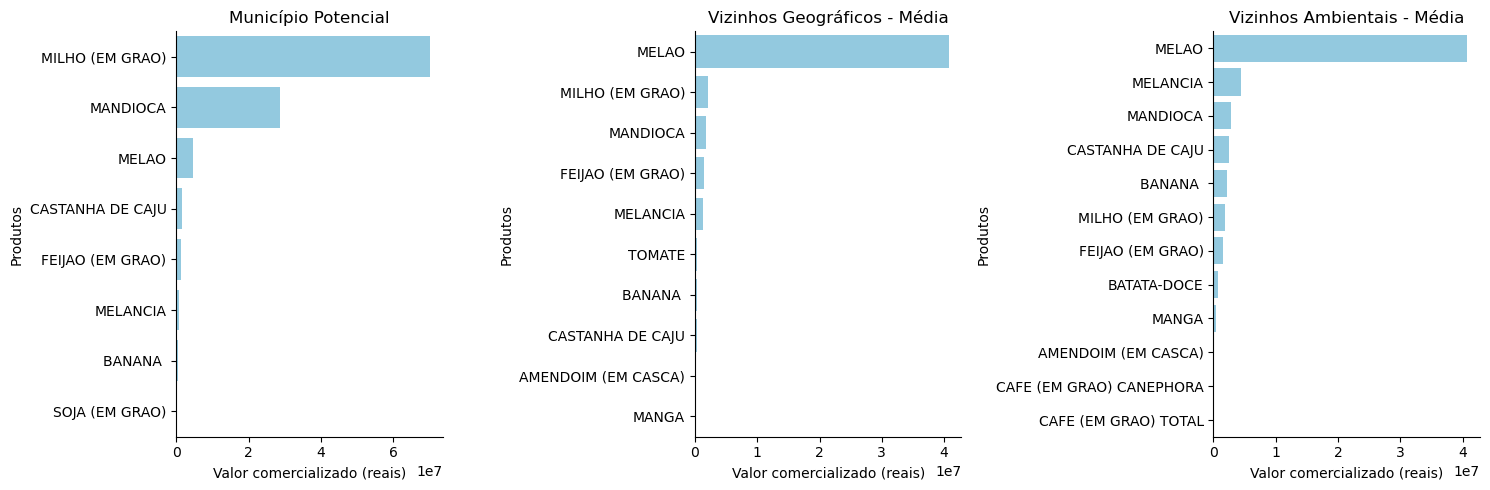

In [140]:
comp_agro('VALOR_PROD', mun_cod, geo, amb)

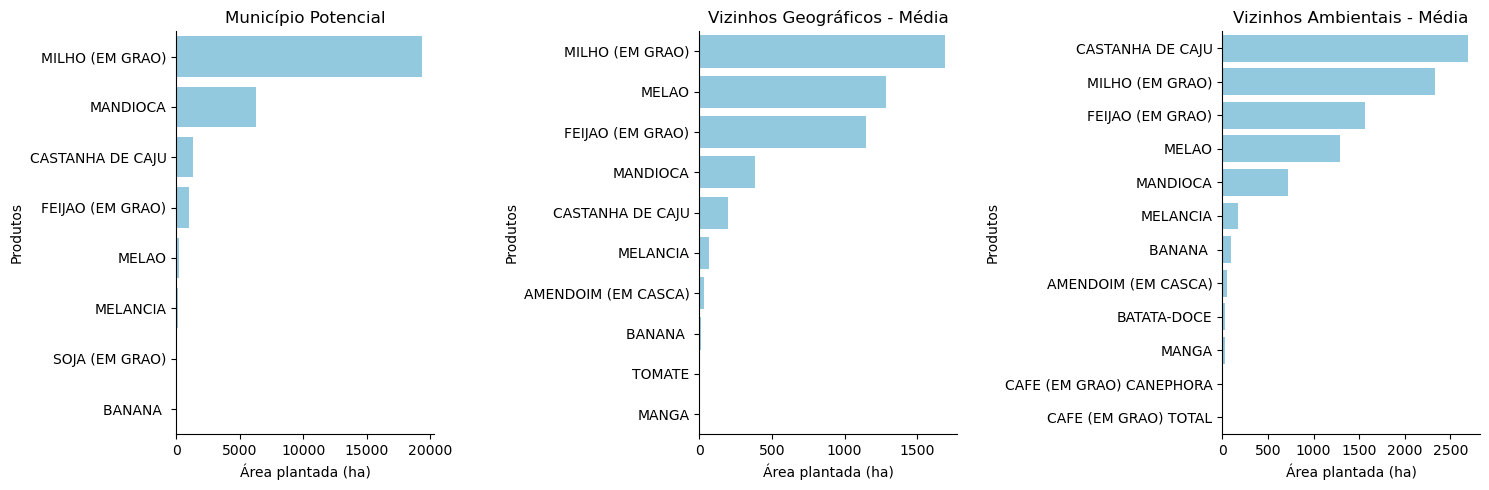

In [141]:
comp_agro('AREA_PLANTADA', mun_cod, geo, amb)

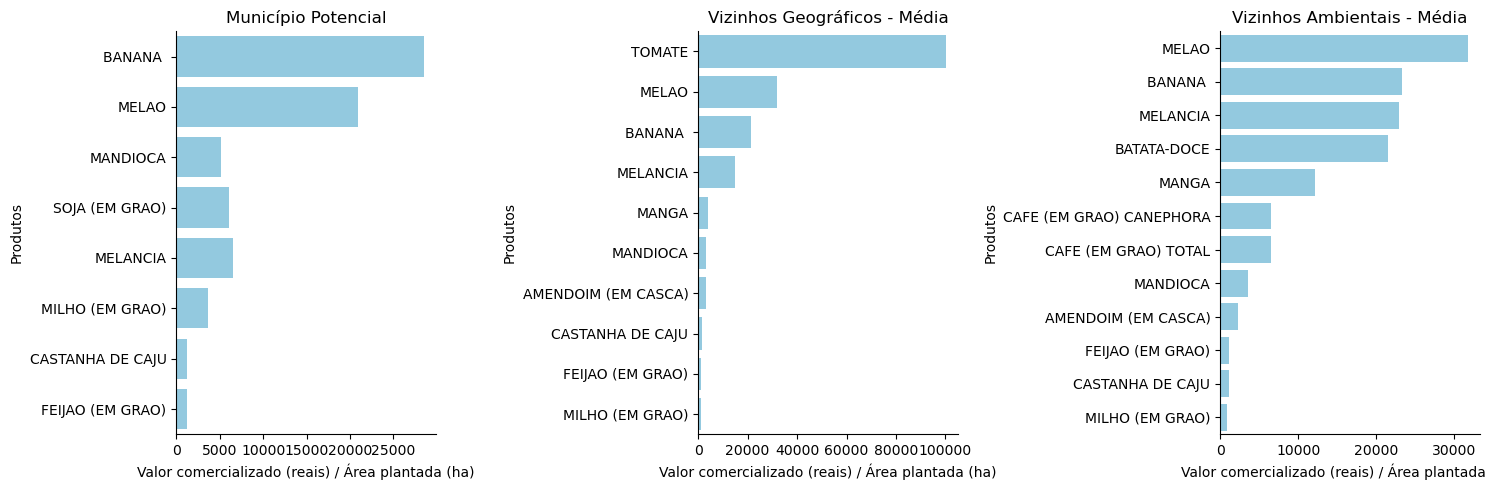

In [142]:
comp_agro('REND_AREA', mun_cod, geo, amb)

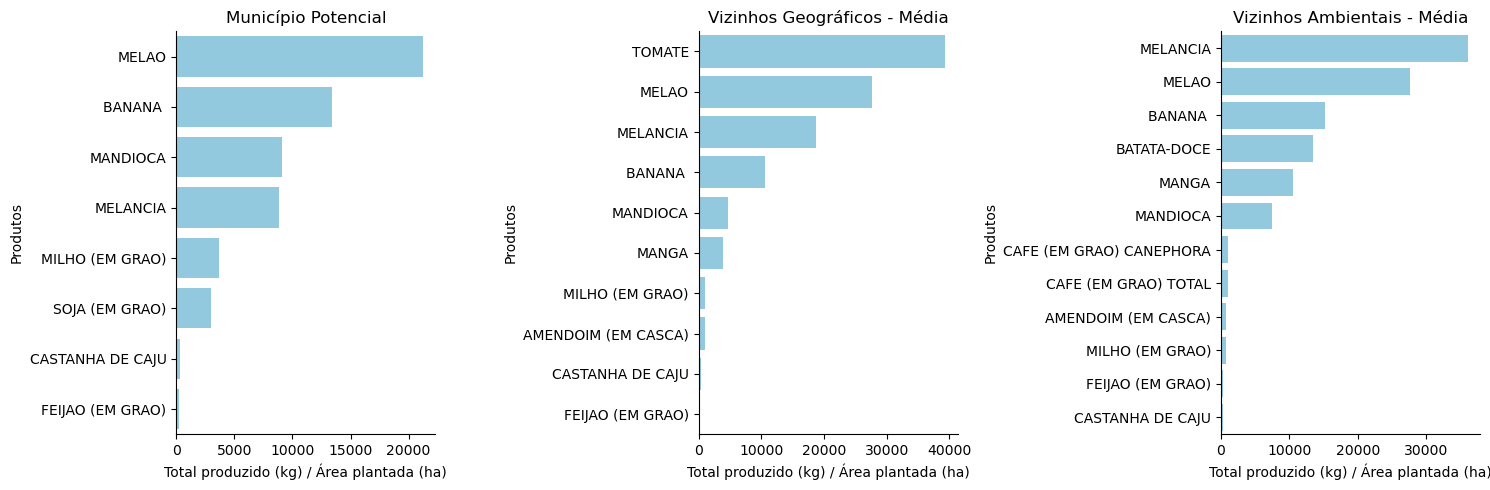

In [143]:
comp_agro('REND_MEDIO', mun_cod, geo, amb)

### 3.3.3) Identificação dos maiores produtores de melão do Sertão

Dado que o melão mostrou ser um produto bem explorado pelos municípios vizinhos e com uma boa rentabilidade, há indicadores de que este pode ser um produto subexplorado em Itapicuru. Logo, foi feita uma investigação para identificar quais são os principais produtores deste fruto no Sertão.

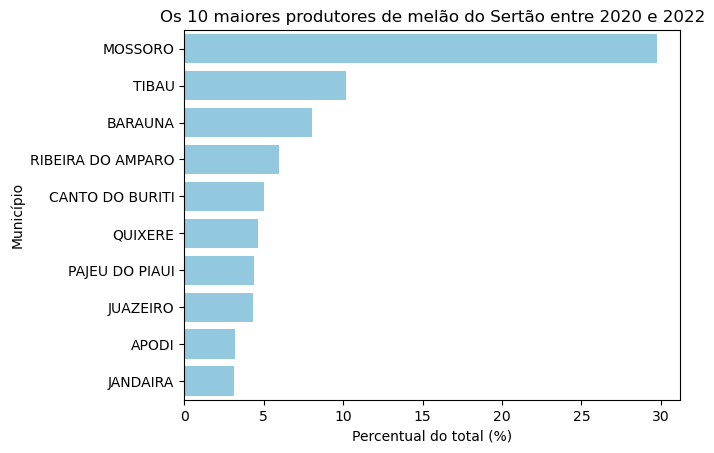

In [144]:
maiores_prod = agro[agro['PRODUTO']=='MELAO'][['NOME', 'VALOR_PROD']]
maiores_prod = maiores_prod.groupby('NOME').mean().reset_index().sort_values(by='VALOR_PROD', ascending = False)
maiores_prod['PERCENTUAL_TOTAL'] = (maiores_prod['VALOR_PROD']/maiores_prod['VALOR_PROD'].sum())*100
sns.barplot(maiores_prod.head(10), x = 'PERCENTUAL_TOTAL', y = 'NOME',color='skyblue',ci=None)
plt.title("Os 10 maiores produtores de melão do Sertão entre 2020 e 2022")
plt.xlabel("Percentual do total (%)")
plt.ylabel("Município")
plt.show()

O gráfico mostra que **Ribeira do Amparo** é um dos quatro maiores produtores de melão da região. Dado que ele é vizinho tanto geográfico quanto ambiental de Itapicuru, foram realizadas análises para avaliar a possibilidade de se replicar com sucesso a exploração.

### 3.3.4) Comparação Itapicuru vs Ribeira do Amparo

#### 3.3.4.1) Clima

In [22]:
bar_plot(
        df = comp_df('PREC_MED', mun_df, all_muns, neighs), 
        x = 'PREC_MED', 
        y = 'NOME', 
        title = 'Precipitação média anual', 
        leg_x = 'Precipitação média anual (mm)',
        leg_y = None ,
        text = 'PREC_MED'
        )

In [23]:
bar_plot(
        df = comp_df('RAD_MED', mun_df, all_muns, neighs), 
        x = 'RAD_MED', 
        y = 'NOME', 
        title = 'Radiação média global', 
        leg_x = 'Radiação média global (Kj/m²)',
        leg_y = None ,
        text = 'RAD_MED'
        )

In [24]:
bar_plot(
        df = comp_df('TEMP_MED', mun_df, all_muns, neighs), 
        x = 'TEMP_MED', 
        y = 'NOME', 
        title = 'Temperatura média diária', 
        leg_x = "Temperatura média diária (°C)",
        leg_y = None ,
        text = 'TEMP_MED'
        )

#### 3.3.4.3) Recursos hídricos

In [25]:
bar_plot(
        df = comp_df('AGUA_SOLO', mun_df, all_muns, neighs), 
        x = 'AGUA_SOLO', 
        y = 'NOME', 
        title = 'Percentual de água do solo', 
        leg_x = 'Percentual de água do solo',
        leg_y = None ,
        text = 'AGUA_SOLO'
        )

In [26]:
bar_plot(
        df = comp_df('AREA_IRRIGADA_TOT', mun_df, all_muns, neighs), 
        x = 'AREA_IRRIGADA_TOT', 
        y = 'NOME', 
        title = 'Área irrigada total', 
        leg_x = 'Área irrigada (ha)',
        leg_y = None ,
        text = 'AREA_IRRIGADA_TOT'
        )

In [27]:
bar_plot(
        df = comp_df('AREA_IRRIGADA_POT_E', mun_df, all_muns, neighs), 
        x = 'AREA_IRRIGADA_POT_E', 
        y = 'NOME', 
        title = 'Área adicional irrigada potencial efetiva', 
        leg_x = 'Área adicional irrigada (ha)',
        leg_y = None ,
        text = 'AREA_IRRIGADA_POT_E'
        )

In [28]:
bar_plot(
        df = comp_df('QUAL_MED_AGUA', mun_df, all_muns, neighs), 
        x = 'QUAL_MED_AGUA', 
        y = 'NOME', 
        title = 'Índice de qualidade média da água', 
        leg_x = 'Índice de qualidade média da água',
        leg_y = None ,
        text = 'QUAL_MED_AGUA'
        )

#### 3.3.4.3) Tipos de solos mais comuns

In [30]:
solos_mun = solos[['SOLO', 'AREA_TOTAL']].loc[solos['NOME']=='ITAPICURU'].sort_values(by='AREA_TOTAL')
solos_prox = solos[solos['NOME'].isin(list(['RIBEIRA DO AMPARO']))]
solos_prox = solos_prox[['SOLO', 'AREA_TOTAL']].groupby('SOLO').sum().reset_index().sort_values(by='AREA_TOTAL')

fig = make_subplots(
    rows=1, 
    cols=2, 
    subplot_titles=('Município potencial', 'Total do(s) vizinho(s)'),
    horizontal_spacing = 0.3
    )
trace1 = px.bar(
    solos_mun,
    x='AREA_TOTAL',
    y='SOLO',
    orientation='h'
)
fig.add_trace(trace1.data[0], row=1, col=1)

trace2 = px.bar(
    solos_prox,
    x='AREA_TOTAL',
    y='SOLO',
    orientation='h'
)
fig.add_trace(trace2.data[0], row=1, col=2)

fig.update_layout(
    title='Tipos de solos mais comuns',
    yaxis=dict(title='Solos'),
    xaxis=dict(title='Área total (ha)')
)

fig.show()

# 4) Avaliação das condições de exploração do melão em Itapicuru

## 4.1) Avaliação das vantagens econômicas da exploração do melão em relação aos outros produtos para a ONG Amigos do Bem

### 4.1.1) Valor produzido

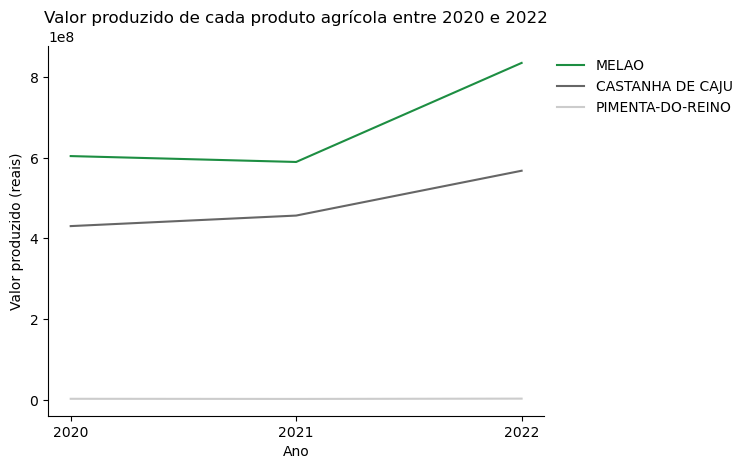

In [169]:
produtos = ['CASTANHA DE CAJU', 'MELAO', 'PIMENTA-DO-REINO']
valor = agro[agro['PRODUTO'].isin(produtos)]
valor = valor[['ANO', 'PRODUTO', 'VALOR_PROD']].groupby(['ANO', 'PRODUTO']).sum().reset_index()
valor['ANO'] = valor['ANO'].astype('str')
nova_ordem = ['MELAO', 'CASTANHA DE CAJU', 'PIMENTA-DO-REINO']
valor['PRODUTO'] = pd.Categorical(valor['PRODUTO'], categories=nova_ordem, ordered=True)

cores = ["#1d8e42","#666666", "#cccccc"]
fig = sns.lineplot(data=valor, x="ANO", y="VALOR_PROD", hue = 'PRODUTO', ci = None, markers=True,palette = cores)
sns.despine()
plt.title("Valor produzido de cada produto agrícola entre 2020 e 2022")
plt.xlabel("Ano")
plt.ylabel("Valor produzido (reais)")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1), title=None, frameon=False)
plt.show()

In [171]:
valor

,ANO,PRODUTO,VALOR_PROD
0,2020,CASTANHA DE CAJU,430629000
1,2020,MELAO,604380000
2,2020,PIMENTA-DO-REINO,2102000
3,2021,CASTANHA DE CAJU,456781000
4,2021,MELAO,589781000
5,2021,PIMENTA-DO-REINO,1777000
6,2022,CASTANHA DE CAJU,568018000
7,2022,MELAO,835559000
8,2022,PIMENTA-DO-REINO,2510000


### 4.1.2) Rentabilidade por área plantada

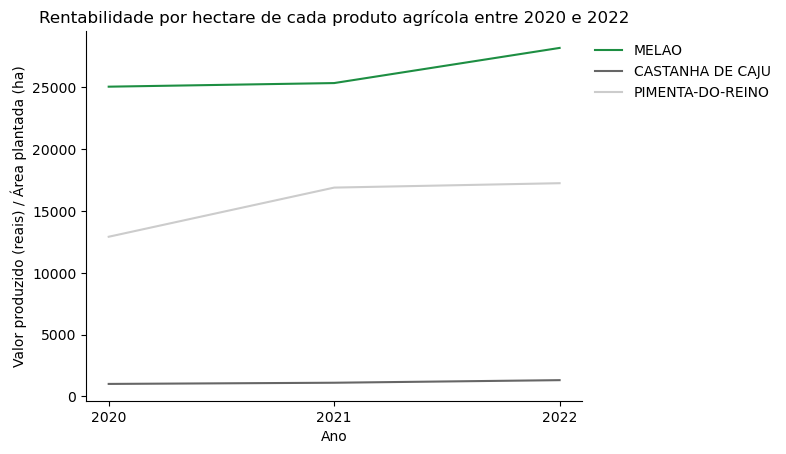

In [173]:
produtos = ['CASTANHA DE CAJU', 'MELAO', 'PIMENTA-DO-REINO']
rent = agro[agro['PRODUTO'].isin(produtos)]
rend = rent[['ANO', 'PRODUTO', 'REND_AREA']].groupby(['ANO', 'REND_AREA']).mean().reset_index()
rent['ANO'] = rent['ANO'].astype('str')
nova_ordem = ['MELAO', 'CASTANHA DE CAJU', 'PIMENTA-DO-REINO']
rent['PRODUTO'] = pd.Categorical(rent['PRODUTO'], categories=nova_ordem, ordered=True)

cores = ["#1d8e42","#666666", "#cccccc"]
fig = sns.lineplot(data=rent, x="ANO", y="REND_AREA", hue = 'PRODUTO', ci = None, markers=True, palette = cores)
sns.despine()
plt.title("Rentabilidade por hectare de cada produto agrícola entre 2020 e 2022")
plt.xlabel("Ano")
plt.ylabel("Valor produzido (reais) / Área plantada (ha)")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1), title=None, frameon=False)
plt.show()

## 4.2) Avaliação da disponibilidade de terras para expansão da agricultura

### 4.2.1) Cálculo da média da área transicionada para cobertura agrícola, agrupada por tipo de bioma

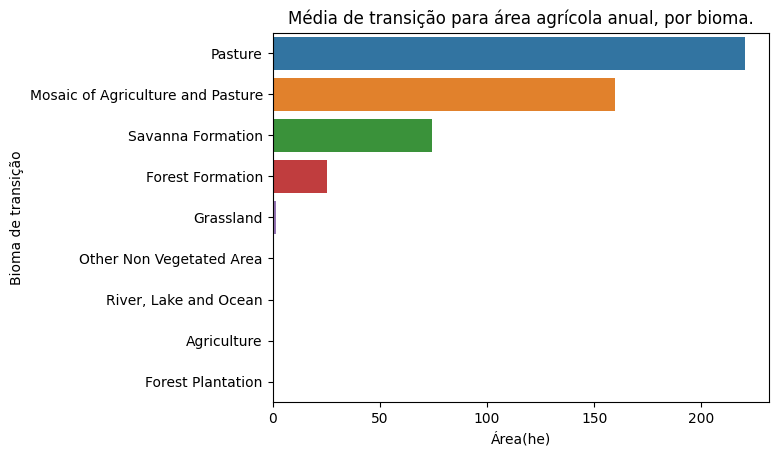

In [13]:
codigo_itapicuru = 2916500
dados_barplot = dados_barplot[dados_barplot["IBGE7"] == codigo_itapicuru]
sns.barplot(dados_barplot, y="from_level_2", x="AREA_TRANSICAO_MEDIA_ANUAL")
plt.ylabel("Bioma de transição")
plt.xlabel("Área(he)")
plt.title("Média de transição para área agrícola anual, por bioma.")
plt.show()

O gráfico acima evidencia que alguns biomas sofrem mais transições do que outros, dado suas condições geomorfológicas e distribução. Pode-se perceber, também, que regiões que já passaram pela a ação do homem sofrem, em média, uma transição para regiões de agricultura, muito grande em comparação com outros tipos de bioma. Entretanto, a distribuição de Formações de Savana e Floresta, são mais interessantes, dado que são biomas que ainda não sofreram ação antrópica e, se qualificam entre o terceiro e quarto lugar de maior transição.

### 4.2.1) Identificação de tendência na dinâmica de área agrícola no município

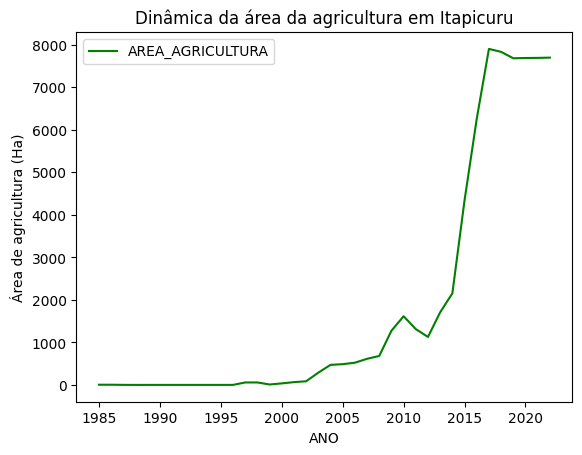

In [19]:
dados_tendencia_agricola = dados_tendencia_agricola[dados_tendencia_agricola["IBGE7"] == codigo_itapicuru]
plot_tendencia(dados_tendencia_agricola)

Pode-se perceber que há uma tendência de expansão de terras agrícolas na região, o que corrobora para as condições deste tipo de investimento.

## 4.3) Avaliação das condições de plantio do melão

# 5) Avaliação do impacto socioeconômico

## 5.1) Calculo do lucro líquido estimado com a expansão da produção 

### 5.1.1) Projeção da população para os próximos 5 anos

### 5.1.2) Projeção da renda per capita para os próximos 5 anos

### 5.1.3) Projeção do PIB para os próximos 5 anos - sem valor adicionado

### 5.1.4) Projeção do PIB para os próximos 5 anos - com valor adicionado

## 5.2) Calculo do impacto social estimado

### 5.2.1) Análise dos indicadores sociais que mais podem ser impactados pelo crescimento da renda per capita

### 5.2.1) Estimação dos ganhos sociais